In [24]:
import json

with open('hyperparameter_search/movielens_100k/IB_BBCF_VANILLA_grid_raw.results', 'r') as file_object:
    IB_BBCF_VANILLA = json.load(file_object)

with open('hyperparameter_search/movielens_100k/IBKNN_grid_raw.results', 'r') as file_object:
    IBKNN = json.load(file_object)

with open('hyperparameter_search/movielens_100k/UBKNN_grid_raw.results', 'r') as file_object:
    UBKNN = json.load(file_object)

with open('hyperparameter_search/movielens_100k/SVD_grid_raw.results', 'r') as file_object:
    SVD = json.load(file_object)

with open('hyperparameter_search/movielens_100k/SVD++_grid_raw.results', 'r') as file_object:
    SVDpp = json.load(file_object)


with open('hyperparameter_search/movielens_100k/UB_BBCF_VANILLA_grid_raw.results', 'r') as file_object:
    UB_BBCF_VANILLA = json.load(file_object)

with open('hyperparameter_search/movielens_100k/IB_BBCF_DOUBLE_WEIGHT_grid_raw.results', 'r') as file_object:
    IB_BBCF_DOUBLE_WEIGHT = json.load(file_object)

with open('hyperparameter_search/movielens_100k/UB_BBCF_DOUBLE_WEIGHT_grid_raw.results', 'r') as file_object:
    UB_BBCF_DOUBLE_WEIGHT = json.load(file_object)

with open('hyperparameter_search/movielens_100k/IB_BBCF_BINAPS_grid_raw.results', 'r') as file_object:
    IB_BBCF_BINAPS = json.load(file_object)


In [25]:
def remove_impossible_solution(solutions):
    possible_solutions = []
    for solution in solutions:
        metrics = solution[1]

        impossible = any(None in values for key, values in metrics.items())
        if not impossible:
            possible_solutions.append(solution)
    return possible_solutions


print(len(IB_BBCF_BINAPS))
IB_BBCF_BINAPS = remove_impossible_solution(IB_BBCF_BINAPS)
print(len(IB_BBCF_BINAPS))

4
2


In [2]:
from evaluation.strategies import (
    PredictionCoverageStrategy,
    MAEStrategy,
    PrecisionAtKStrategy,
    RecallAtKStrategy,
    NDCGStrategy,
    F1ScoreStrategy,
)

objectives = [PredictionCoverageStrategy, MAEStrategy]
# objectives = [PredictionCoverageStrategy, PrecisionAtKStrategy]
# objectives = [PredictionCoverageStrategy, RecallAtKStrategy(k=20)]
# objectives = [PredictionCoverageStrategy, NDCGStrategy]
# objectives = [PredictionCoverageStrategy, F1ScoreStrategy]

In [3]:
import numpy as np


def dominates(a, b, objectives):

    partial_result = []
    for objective in objectives:
        direction = 1 if objective.is_better_higher() else -1

        a_mean = np.mean(a[objective.get_name()])
        b_mean = np.mean(b[objective.get_name()])

        if direction * a_mean >= direction * b_mean:
            partial_result.append(True)
        else:
            partial_result.append(False)

    return all(partial_result)


# a = {"prediction_coverage": [1, 1, 1, 1, 1], "mae": [1, 1, 1, 1, 1]}
# b = {"prediction_coverage": [1, 1, 1, 1, 1], "mae": [1, 1, 1, 1, 0]}
# c = {"prediction_coverage": [1, 1, 1, 1, 1], "mae": [1, 1, 1, 0, 0]}
# print(dominates(a, b, objectives))

In [4]:
def get_all_strongly_dominated_solutions(solution, solutions, objectives):
    return [id for id, s in enumerate(solutions) if dominates(solution[1], s[1], objectives)]

# # test
# solutions = [(1, a), (2, b), (3, c)]
# print(get_all_strongly_dominated_solutions(solutions[2], solutions, objectives))

In [5]:
import numpy as np


def remove_indices(lst, indices):
    list_with_indices_removed = [el for i, el in enumerate(lst) if i not in indices]
    indices_removed = [el for i, el in enumerate(lst) if i in indices]
    return list_with_indices_removed, indices_removed


def get_pareto_frontier(solutions, objectives):

    pareto_frontier = solutions
    dominated_solutions = []

    searching = True
    while searching:
        for solution_id, solution in enumerate(pareto_frontier):

            pareto_frontier_without_solution = [
                s for i, s in enumerate(pareto_frontier) if i != solution_id
            ]

            strongly_dominated_solutions = get_all_strongly_dominated_solutions(
                solution, pareto_frontier_without_solution, objectives
            )
            if strongly_dominated_solutions:
                pareto_frontier_without_solution, removed = remove_indices(
                    pareto_frontier_without_solution, strongly_dominated_solutions
                )
                pareto_frontier_without_solution.append(solution)
                pareto_frontier = pareto_frontier_without_solution
                dominated_solutions += removed
                break
        else:
            searching = False

    return pareto_frontier, dominated_solutions

In [18]:
UB_BBCF_VANILLA_pareto_frontier, UB_BBCF_VANILLA_dominated_solutions = get_pareto_frontier(
    UB_BBCF_VANILLA, objectives
)
IB_BBCF_VANILLA_pareto_frontier, IB_BBCF_VANILLA_dominated_solutions = get_pareto_frontier(
    IB_BBCF_VANILLA, objectives
)
IBKNN_pareto_frontier, IBKNN_dominated_solutions = get_pareto_frontier(IBKNN, objectives)
UBKNN_pareto_frontier, UBKNN_dominated_solutions = get_pareto_frontier(UBKNN, objectives)
SVD_pareto_frontier, SVD_dominated_solutions = get_pareto_frontier(SVD, objectives)
SVDpp_pareto_frontier, SVDpp_dominated_solutions = get_pareto_frontier(SVDpp, objectives)
IB_BBCF_DOUBLE_WEIGHT_pareto_frontier, IB_BBCF_DOUBLE_WEIGHT_dominated_solutions = (
    get_pareto_frontier(IB_BBCF_DOUBLE_WEIGHT, objectives)
)
UB_BBCF_DOUBLE_WEIGHT_pareto_frontier, UB_BBCF_DOUBLE_WEIGHT_dominated_solutions = (
    get_pareto_frontier(UB_BBCF_DOUBLE_WEIGHT, objectives)
)
IB_BBCF_BINAPS_pareto_frontier, IB_BBCF_BINAPS_dominated_solutions = get_pareto_frontier(
    IB_BBCF_BINAPS, objectives
)

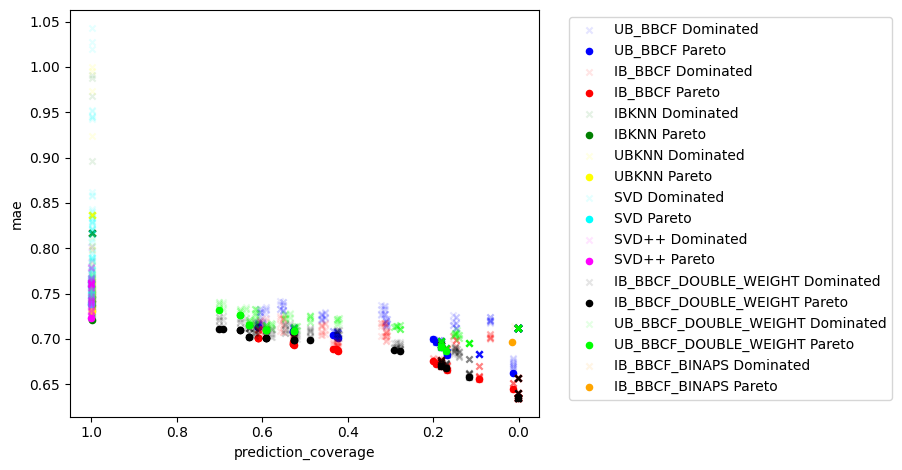

In [27]:
import matplotlib.pyplot as plt


def plot_pareto_frontier(solutions, objectives):

    colors = ["blue", "red", "green", "yellow", "cyan", "magenta", "black", "lime", "orange", "purple", "pink"]

    for color, (name, pareto_frontier, dominated_solutions) in enumerate(solutions):

        objective_1_name = objectives[0].get_name()
        objective_1_direction = objectives[0].is_better_higher()

        objective_2_name = objectives[1].get_name()
        objective_2_direction = objectives[1].is_better_higher()

        objective_1_dominated = [
            np.mean(execution[1][objective_1_name]) for execution in dominated_solutions
        ]
        objective_2_dominated = [
            np.mean(execution[1][objective_2_name]) for execution in dominated_solutions
        ]

        objective_1_pareto = [
            np.mean(execution[1][objective_1_name]) for execution in pareto_frontier
        ]
        objective_2_pareto = [
            np.mean(execution[1][objective_2_name]) for execution in pareto_frontier
        ]

        plt.scatter(
            objective_1_dominated,
            objective_2_dominated,
            label=f"{name} Dominated",
            color=colors[color],
            marker="x",
            alpha=0.1,
            s=20,
        )
        plt.scatter(
            objective_1_pareto,
            objective_2_pareto,
            label=f"{name} Pareto",
            color=colors[color],
            marker="o",
            s=20,
        )

    if objective_1_direction:
        plt.gca().invert_xaxis()

    if objective_2_direction:
        plt.gca().invert_yaxis()

    plt.xlabel(objective_1_name)
    plt.ylabel(objective_2_name)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.subplots_adjust(right=0.85)  # Adjust this value as needed
    plt.show()


plot_pareto_frontier(
    [
        ("UB_BBCF", UB_BBCF_VANILLA_pareto_frontier, UB_BBCF_VANILLA_dominated_solutions),
        ("IB_BBCF", IB_BBCF_VANILLA_pareto_frontier, IB_BBCF_VANILLA_dominated_solutions),
        ("IBKNN", IBKNN_pareto_frontier, IBKNN_dominated_solutions),
        ("UBKNN", UBKNN_pareto_frontier, UBKNN_dominated_solutions),
        ("SVD", SVD_pareto_frontier, SVD_dominated_solutions),
        ("SVD++", SVDpp_pareto_frontier, SVDpp_dominated_solutions),
        (
            "IB_BBCF_DOUBLE_WEIGHT",
            IB_BBCF_DOUBLE_WEIGHT_pareto_frontier,
            IB_BBCF_DOUBLE_WEIGHT_dominated_solutions,
        ),
        (
            "UB_BBCF_DOUBLE_WEIGHT",
            UB_BBCF_DOUBLE_WEIGHT_pareto_frontier,
            UB_BBCF_DOUBLE_WEIGHT_dominated_solutions,
        ),
        (
            "IB_BBCF_BINAPS",
            IB_BBCF_BINAPS_pareto_frontier,
            IB_BBCF_BINAPS_dominated_solutions,
        ),
    ],
    objectives,
)

In [8]:
all_solutions = [
    ("UB_BBCF", UB_BBCF_VANILLA),
    ("IB_BBCF", IB_BBCF_VANILLA),
    ("IBKNN", IBKNN),
    ("UBKNN", UBKNN),
    ("SVD", SVD),
    ("SVD++", SVDpp),
    ("IB_BBCF_DOUBLE_WEIGHT", IB_BBCF_DOUBLE_WEIGHT),
    ("UB_BBCF_DOUBLE_WEIGHT", UB_BBCF_DOUBLE_WEIGHT),
]

def combine_solutions(labeled_solutions):
    combined_solutions = []
    for label, solutions in labeled_solutions:
        for solution in solutions:
            solution[0]["name"] = label
        combined_solutions += solutions
    return combined_solutions

combined_solutions = combine_solutions(all_solutions)

combined_pareto_frontier, combined_dominated_solutions = get_pareto_frontier(
    combined_solutions, objectives
)


def sort_pareto_frontier(pareto_frontier, all_solutions):
    sorted_pareto_frontier = {}
    for label, _ in all_solutions:
        sorted_pareto_frontier[label] = []

    for solution in pareto_frontier:
        sorted_pareto_frontier[solution[0]["name"]].append(solution)

    return sorted_pareto_frontier

sorted_pareto = sort_pareto_frontier(combined_pareto_frontier, all_solutions)

In [9]:
for label, pareto in sorted_pareto.items():
    print(f"{label} Pareto: {len(pareto)}")


UB_BBCF Pareto: 0
IB_BBCF Pareto: 19
IBKNN Pareto: 1
UBKNN Pareto: 0
SVD Pareto: 0
SVD++ Pareto: 1
IB_BBCF_DOUBLE_WEIGHT Pareto: 8
UB_BBCF_DOUBLE_WEIGHT Pareto: 0


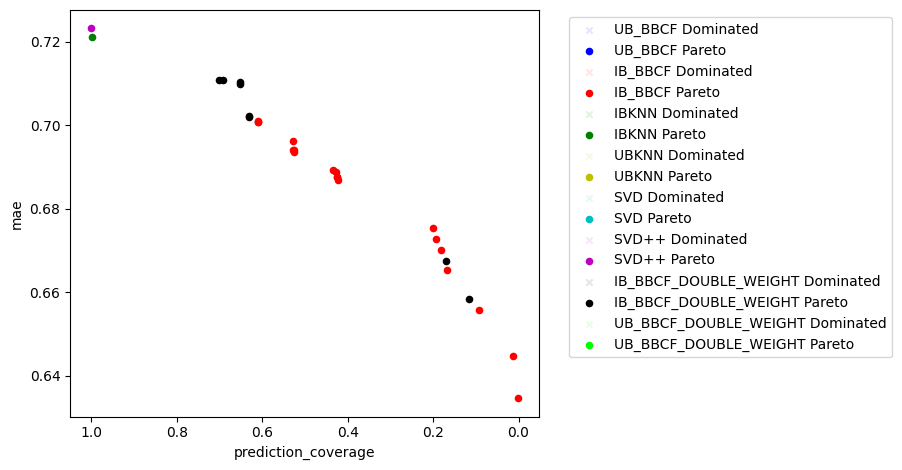

In [10]:
plot_pareto_frontier(
    [
        (label, pareto, []) for label, pareto in sorted_pareto.items()
    ],
    objectives,
)

UB_BBCF Pareto: 0
IB_BBCF Pareto: 0
IBKNN Pareto: 0
UBKNN Pareto: 0
SVD Pareto: 1
SVD++ Pareto: 1
IB_BBCF_DOUBLE_WEIGHT Pareto: 2
UB_BBCF_DOUBLE_WEIGHT Pareto: 0


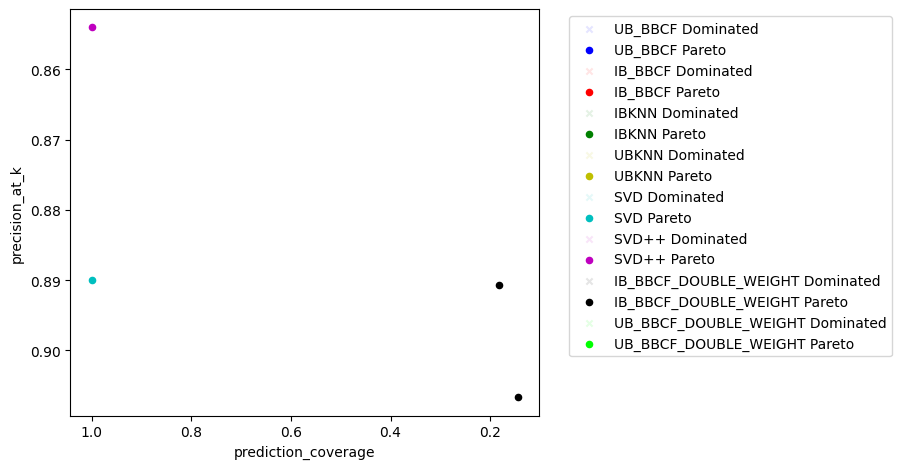

In [11]:
objectives = [PredictionCoverageStrategy, PrecisionAtKStrategy]

combined_pareto_frontier, combined_dominated_solutions = get_pareto_frontier(
    combined_solutions, objectives
)

sorted_pareto = sort_pareto_frontier(combined_pareto_frontier, all_solutions)

for label, pareto in sorted_pareto.items():
    print(f"{label} Pareto: {len(pareto)}")

plot_pareto_frontier(
    [
        (label, pareto, []) for label, pareto in sorted_pareto.items()
    ],
    objectives,
)

UB_BBCF Pareto: 11
IB_BBCF Pareto: 0
IBKNN Pareto: 0
UBKNN Pareto: 1
SVD Pareto: 0
SVD++ Pareto: 1
IB_BBCF_DOUBLE_WEIGHT Pareto: 1
UB_BBCF_DOUBLE_WEIGHT Pareto: 1


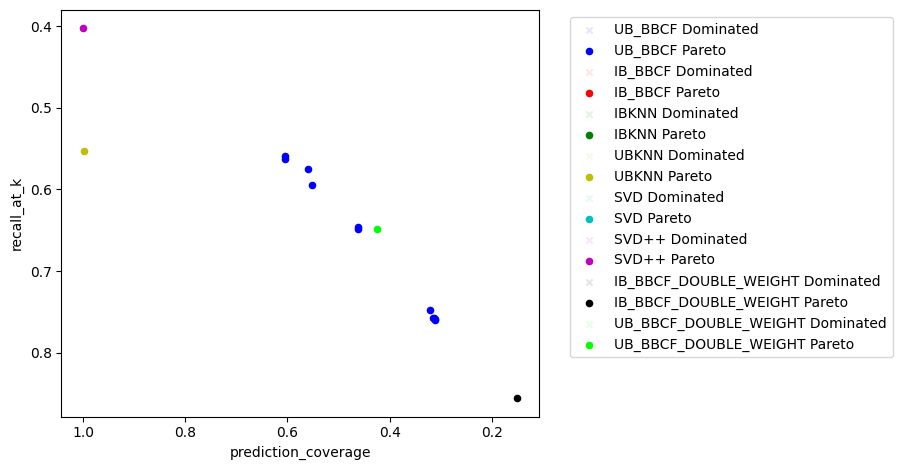

In [12]:
objectives = [PredictionCoverageStrategy, RecallAtKStrategy]

combined_pareto_frontier, combined_dominated_solutions = get_pareto_frontier(
    combined_solutions, objectives
)

sorted_pareto = sort_pareto_frontier(combined_pareto_frontier, all_solutions)

for label, pareto in sorted_pareto.items():
    print(f"{label} Pareto: {len(pareto)}")

plot_pareto_frontier(
    [
        (label, pareto, []) for label, pareto in sorted_pareto.items()
    ],
    objectives,
)

UB_BBCF Pareto: 10
IB_BBCF Pareto: 0
IBKNN Pareto: 1
UBKNN Pareto: 0
SVD Pareto: 1
SVD++ Pareto: 0
IB_BBCF_DOUBLE_WEIGHT Pareto: 8
UB_BBCF_DOUBLE_WEIGHT Pareto: 0


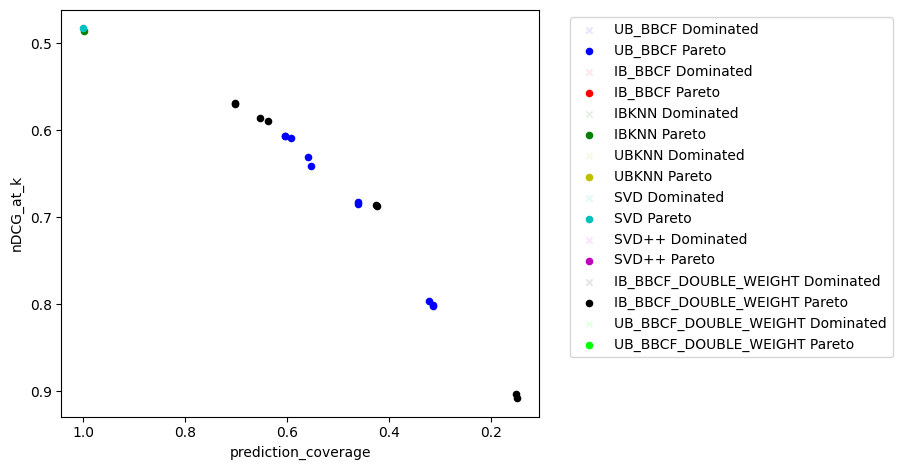

In [13]:
objectives = [PredictionCoverageStrategy, NDCGStrategy]

combined_pareto_frontier, combined_dominated_solutions = get_pareto_frontier(
    combined_solutions, objectives
)

sorted_pareto = sort_pareto_frontier(combined_pareto_frontier, all_solutions)

for label, pareto in sorted_pareto.items():
    print(f"{label} Pareto: {len(pareto)}")

plot_pareto_frontier(
    [
        (label, pareto, []) for label, pareto in sorted_pareto.items()
    ],
    objectives,
)

UB_BBCF Pareto: 6
IB_BBCF Pareto: 2
IBKNN Pareto: 0
UBKNN Pareto: 1
SVD Pareto: 0
SVD++ Pareto: 1
IB_BBCF_DOUBLE_WEIGHT Pareto: 1
UB_BBCF_DOUBLE_WEIGHT Pareto: 4


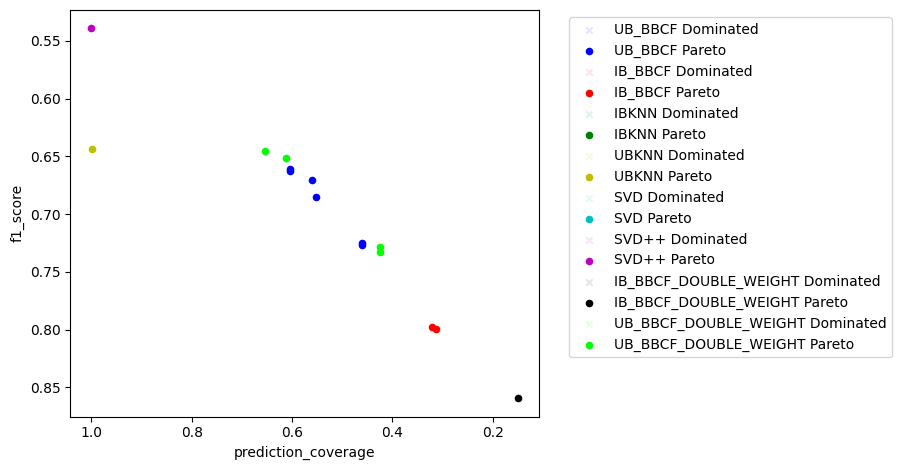

In [14]:
objectives = [PredictionCoverageStrategy, F1ScoreStrategy]

combined_pareto_frontier, combined_dominated_solutions = get_pareto_frontier(
    combined_solutions, objectives
)

sorted_pareto = sort_pareto_frontier(combined_pareto_frontier, all_solutions)

for label, pareto in sorted_pareto.items():
    print(f"{label} Pareto: {len(pareto)}")

plot_pareto_frontier(
    [
        (label, pareto, []) for label, pareto in sorted_pareto.items()
    ],
    objectives,
)